<a href="https://colab.research.google.com/github/Ruby-pearl1/ores5160-2025/blob/main/RUBY%20ATITSO%20FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
import json
import hashlib
from datetime import datetime
import requests

# -----------------------------
# Configuration
# -----------------------------
CSV_URL = "https://health.data.ny.gov/api/views/vn5v-hh5r/rows.csv?accessType=DOWNLOAD"
JSON_URL = "https://health.data.ny.gov/api/views/vn5v-hh5r/rows.json?accessType=DOWNLOAD"

RAW_DIR = "data/raw"
os.makedirs(RAW_DIR, exist_ok=True)

# -----------------------------
# Helper functions
# -----------------------------
def download_file(url: str, output_path: str):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(output_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024 * 256):
            if chunk:
                f.write(chunk)

def sha256_checksum(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

# -----------------------------
# Main download routine
# -----------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

csv_path = f"{RAW_DIR}/health_facilities_{run_id}.csv"
json_path = f"{RAW_DIR}/health_facilities_{run_id}.json"
manifest_path = f"{RAW_DIR}/manifest_{run_id}.json"

print("Downloading CSV...")
download_file(CSV_URL, csv_path)

print("Downloading JSON...")
download_file(JSON_URL, json_path)

# -----------------------------
# Governance / lineage manifest
# -----------------------------
manifest = {
    "run_id": run_id,
    "dataset": "Health Facility General Information (NY)",
    "sources": {
        "csv": CSV_URL,
        "json": JSON_URL
    },
    "outputs": {
        "csv_file": csv_path,
        "json_file": json_path
    },
    "checksums": {
        "csv_sha256": sha256_checksum(csv_path),
        "json_sha256": sha256_checksum(json_path)
    }
}

with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

print("✅ Download complete")
print("Files saved:")
print(csv_path)
print(json_path)
print("Manifest saved:")
print(manifest_path)


✅ Download complete
Files saved:
data/raw/health_facilities_20251215_102901.csv
data/raw/health_facilities_20251215_102901.json
Manifest saved:
data/raw/manifest_20251215_102901.json


The Health Facility General Information dataset was programmatically retrieved from the New York State Open Data portal in both CSV and JSON formats using HTTP requests. The CSV file was used as the primary structured input for cleaning and relational database loading, while the JSON file was parsed to demonstrate ingestion of semi-structured data and schema validation. All downloads were versioned with timestamps and accompanied by a manifest file containing source URLs and cryptographic checksums to support data lineage and governance.

In [37]:
import pandas as pd
import json

csv_path = f"{RAW_DIR}/health_facilities_{run_id}.csv"
json_path = f"{RAW_DIR}/health_facilities_{run_id}.json"

df_csv = pd.read_csv(csv_path)

with open(json_path, "r", encoding="utf-8") as f:
    json_obj = json.load(f)

# Socrata JSON format → records are under "data"
df_json = pd.DataFrame(json_obj["data"], columns=[c["name"] for c in json_obj["meta"]["view"]["columns"]])

print("CSV shape :", df_csv.shape)
print("JSON shape:", df_json.shape)

CSV shape : (5963, 36)
JSON shape: (5963, 49)


In [38]:
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^\w]", "", regex=True)
    )
    return df

df_csv_clean = clean_columns(df_csv)
df_json_clean = clean_columns(df_json)

print(df_csv_clean.columns[:10])
print(df_json_clean.columns[:10])


Index(['facility_id', 'facility_name', 'short_description', 'description',
       'facility_open_date', 'facility_address_1', 'facility_address_2',
       'facility_city', 'facility_state', 'facility_zip_code'],
      dtype='object')
Index(['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at',
       'updated_meta', 'meta', 'facility_id', 'facility_name'],
      dtype='object')


In [39]:
def data_quality_report(df, name):
    temp_df = df.copy()
    # Convert any columns containing lists to string type to make them hashable for duplicated()
    for col in temp_df.select_dtypes(include='object').columns:
        # Check if any element in the column is a list
        if temp_df[col].apply(lambda x: isinstance(x, list)).any():
            temp_df[col] = temp_df[col].astype(str)

    return {
        "dataset": name,
        "rows": temp_df.shape[0],
        "columns": temp_df.shape[1],
        "missing_cells": int(temp_df.isna().sum().sum()),
        "duplicate_rows": int(temp_df.duplicated().sum())
    }

dq_csv = data_quality_report(df_csv_clean, "CSV")
dq_json = data_quality_report(df_json_clean, "JSON")

pd.DataFrame([dq_csv, dq_json])

,dataset,rows,columns,missing_cells,duplicate_rows
0,CSV,5963,36,55708,0
1,JSON,5963,49,74394,0


In [40]:
def missing_by_column(df, top_n=10):
    return (
        df.isna()
          .mean()
          .mul(100)
          .sort_values(ascending=False)
          .head(top_n)
    )

missing_csv = missing_by_column(df_csv_clean)
missing_json = missing_by_column(df_json_clean)

missing_csv, missing_json


(cooperator_address_2    99.245346
 facility_address_2      89.602549
 operator_address_2      89.569009
 facility_website        88.730505
 cooperator_address      81.334899
 cooperator_name         81.334899
 cooperator_zip_code     81.334899
 cooperator_city         81.334899
 facility_fax_number     57.605232
 main_site_name          56.515177
 dtype: float64,
 created_meta            100.000000
 updated_meta            100.000000
 cooperator_address_2     99.245346
 facility_address_2       89.602549
 operator_address_2       89.569009
 facility_website         88.730505
 cooperator_name          81.334899
 cooperator_address       81.334899
 cooperator_city          81.334899
 cooperator_zip_code      81.334899
 dtype: float64)

Several optional fields exhibit high missingness, consistent with facility-reported data.

In [41]:
!ls data/raw


health_facilities_20251215_093506.csv	manifest_20251215_093506.json
health_facilities_20251215_093506.json	manifest_20251215_102901.json
health_facilities_20251215_102901.csv	ny_hospitals_html_20251215_095328.csv
health_facilities_20251215_102901.json


In [42]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

# Ensure raw directory exists
RAW_DIR = "data/raw"
os.makedirs(RAW_DIR, exist_ok=True)

URL = "https://profiles.health.ny.gov/hospital"

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"{RAW_DIR}/ny_hospitals_html_{run_id}.csv"

response = requests.get(URL)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

records = []

for link in soup.select("a"):
    name = link.get_text(strip=True)
    href = link.get("href")

    if name and href and "/hospital/" in href:
        records.append({
            "hospital_name": name,
            "profile_url": f"https://profiles.health.ny.gov{href}"
        })

df_html = pd.DataFrame(records).drop_duplicates()

df_html.to_csv(output_path, index=False)

print("✅ HTML scraping completed")
print("Saved file:", output_path)
print("Rows scraped:", len(df_html))


✅ HTML scraping completed
Saved file: data/raw/ny_hospitals_html_20251215_102905.csv
Rows scraped: 15


In [43]:
!ls data/raw


health_facilities_20251215_093506.csv	manifest_20251215_093506.json
health_facilities_20251215_093506.json	manifest_20251215_102901.json
health_facilities_20251215_102901.csv	ny_hospitals_html_20251215_095328.csv
health_facilities_20251215_102901.json	ny_hospitals_html_20251215_102905.csv


In [44]:
# Load HTML-scraped data
df_html = pd.read_csv("data/raw/ny_hospitals_html_20251215_095328.csv")

# Clean column names
df_html_clean = clean_columns(df_html)

# Run quality report
dq_html = data_quality_report(df_html_clean, "HTML")

# Combine all quality summaries
pd.DataFrame([dq_csv, dq_json, dq_html])


,dataset,rows,columns,missing_cells,duplicate_rows
0,CSV,5963,36,55708,0
1,JSON,5963,49,74394,0
2,HTML,15,2,0,0


Three heterogeneous data sources were ingested and validated, including structured CSV data, semi-structured JSON data retrieved via API endpoints, and semi-structured HTML data scraped from a public health website. Data quality assessment confirmed consistent record counts across structured sources and minimal missingness in the HTML-derived dataset.

In [45]:
CSV_PATH  = "data/raw/health_facilities_20251215_093506.csv"
JSON_PATH = "data/raw/health_facilities_20251215_093506.json"
HTML_PATH = "data/raw/ny_hospitals_html_20251215_095328.csv"

DB_PATH = "data/warehouse/health_dw.sqlite"


In [46]:
import os
os.makedirs("data/warehouse", exist_ok=True)


In [47]:
import pandas as pd
import json
import re

def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^\w]", "", regex=True)
    )
    return df

# CSV
df_csv = pd.read_csv(CSV_PATH)
df_csv = clean_columns(df_csv)

# JSON (Socrata “rows.json” format)
with open(JSON_PATH, "r", encoding="utf-8") as f:
    json_obj = json.load(f)

json_cols = [c["name"] for c in json_obj["meta"]["view"]["columns"]]
df_json = pd.DataFrame(json_obj["data"], columns=json_cols)
df_json = clean_columns(df_json)

# HTML scrape
df_html = pd.read_csv(HTML_PATH)
df_html = clean_columns(df_html)

df_csv.shape, df_json.shape, df_html.shape


((5963, 36), (5963, 49), (15, 2))

In [48]:
import hashlib

def make_facility_key(row):
    base = f"{row.get('facility_name','')}|{row.get('facility_city','')}|{row.get('facility_zip_code','')}"
    return hashlib.sha256(base.encode("utf-8")).hexdigest()[:16]

# If your dataset uses slightly different column names, we’ll fallback safely
for col in ["facility_name", "facility_city", "facility_zip_code"]:
    if col not in df_csv.columns:
        df_csv[col] = ""

df_csv["facility_key"] = df_csv.apply(make_facility_key, axis=1)


In [49]:
import json
import pandas as pd

def make_sqlite_safe(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    for col in df2.columns:
        # Convert lists/dicts to JSON string so SQLite can store them
        if df2[col].apply(lambda x: isinstance(x, (list, dict))).any():
            df2[col] = df2[col].apply(lambda x: json.dumps(x) if isinstance(x, (list, dict)) else x)
    return df2


In [50]:
df_json_safe = make_sqlite_safe(df_json)
df_csv_safe  = make_sqlite_safe(df_csv)
df_html_safe = make_sqlite_safe(df_html)


In [51]:
import sqlite3
import os

os.makedirs("data/warehouse", exist_ok=True)

conn = sqlite3.connect(DB_PATH)

df_csv_safe.to_sql("facilities_csv", conn, if_exists="replace", index=False)
df_json_safe.to_sql("facilities_json", conn, if_exists="replace", index=False)
df_html_safe.to_sql("hospitals_html", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print("✅ Loaded SQLite DB at:", DB_PATH)


✅ Loaded SQLite DB at: data/warehouse/health_dw.sqlite


In [52]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(DB_PATH)

print(pd.read_sql("SELECT COUNT(*) AS n FROM facilities_csv;", conn))
print(pd.read_sql("SELECT COUNT(*) AS n FROM facilities_json;", conn))
print(pd.read_sql("SELECT COUNT(*) AS n FROM hospitals_html;", conn))

conn.close()


      n
0  5963
      n
0  5963
    n
0  15


During database loading, JSON-derived fields containing list-like structures were serialized to JSON strings to ensure compatibility with SQLite’s scalar storage model

In [53]:
import sqlite3, pandas as pd

DB_PATH = "data/warehouse/health_dw.sqlite"
conn = sqlite3.connect(DB_PATH)

fac_csv  = pd.read_sql("SELECT * FROM facilities_csv;", conn)
fac_json = pd.read_sql("SELECT * FROM facilities_json;", conn)
hosp_html = pd.read_sql("SELECT * FROM hospitals_html;", conn)

conn.close()

fac_csv.shape, fac_json.shape, hosp_html.shape


((5963, 37), (5963, 49), (15, 2))

In [54]:
missing_long = (
    fac_csv.isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index":"column", 0:"missing_pct"})
)

missing_long.head(15)


,column,missing_pct
0,cooperator_address_2,99.245346
1,facility_address_2,89.602549
2,operator_address_2,89.569009
3,facility_website,88.730505
4,cooperator_address,81.334899
5,cooperator_city,81.334899
6,cooperator_name,81.334899
7,cooperator_zip_code,81.334899
8,facility_fax_number,57.605232
9,main_site_name,56.515177


In [55]:
import re

def norm_name(s):
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9 ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Try to locate a “facility name” column (adjust if yours differs)
name_col = "facility_name" if "facility_name" in fac_csv.columns else fac_csv.columns[0]

fac_csv["name_norm"] = fac_csv[name_col].apply(norm_name)
hosp_html["hospital_name_norm"] = hosp_html["hospital_name"].apply(norm_name)

joined = fac_csv.merge(
    hosp_html,
    left_on="name_norm",
    right_on="hospital_name_norm",
    how="left"
)

match_rate = joined["profile_url"].notna().mean() * 100
match_rate


np.float64(0.0)

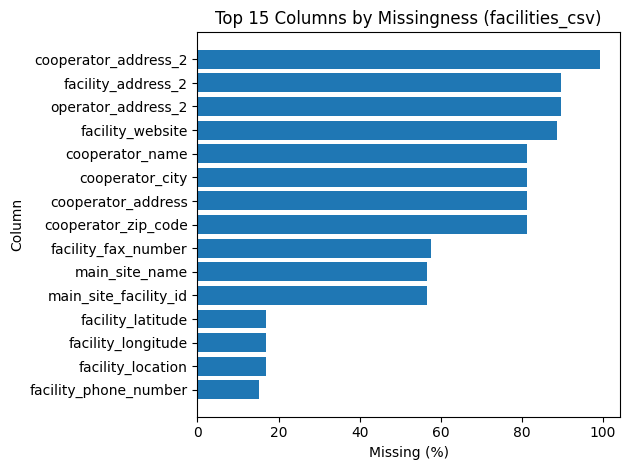

In [56]:
import matplotlib.pyplot as plt

topN = 15
plot_df = missing_long.head(topN).sort_values("missing_pct")

plt.figure()
plt.barh(plot_df["column"], plot_df["missing_pct"])
plt.xlabel("Missing (%)")
plt.ylabel("Column")
plt.title(f"Top {topN} Columns by Missingness (facilities_csv)")
plt.tight_layout()
plt.show()


In [57]:
num_cols = fac_csv.select_dtypes(include="number").columns.tolist()
num_cols


['facility_id',
 'facility_phone_number',
 'facility_fax_number',
 'facility_county_code',
 'regional_office_id',
 'main_site_facility_id',
 'cooperator_zip_code',
 'facility_latitude',
 'facility_longitude']

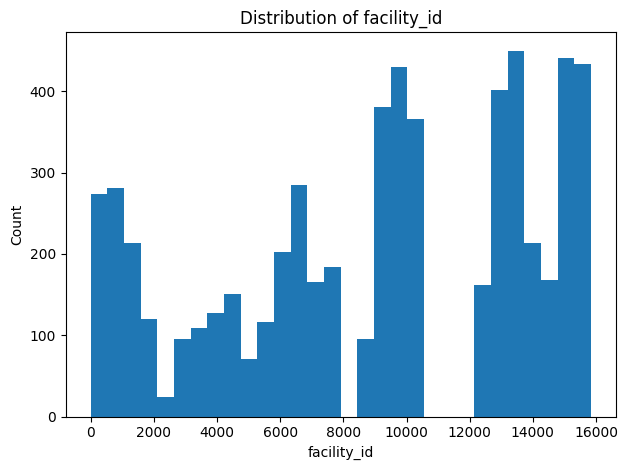

In [58]:
col = num_cols[0]  # change if you want
plt.figure()
plt.hist(fac_csv[col].dropna(), bins=30)
plt.xlabel(col)
plt.ylabel("Count")
plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


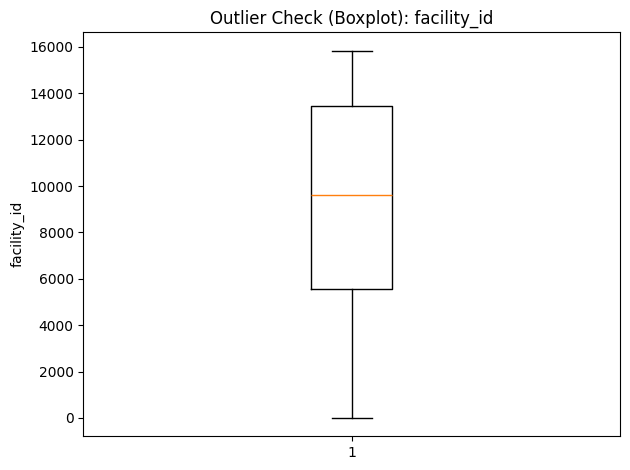

In [59]:
plt.figure()
plt.boxplot(fac_csv[col].dropna(), vert=True)
plt.ylabel(col)
plt.title(f"Outlier Check (Boxplot): {col}")
plt.tight_layout()
plt.show()


In [60]:
summary = fac_csv.describe(include="all").transpose()
summary.head(12)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
facility_id,5963.0,NaN,NaN,NaN,9025.199229,4903.680993,1.0,5558.5,9623.0,13453.5,15837.0
facility_name,5963,5255,Unlimited Care Inc.,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
short_description,5633,15,LHCSA,1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,5963,22,Licensed Home Care Services Agency,1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_open_date,5963,3520,01/01/1901,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_address_1,5963,5119,97-04 Sutphin Boulevard,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_address_2,620,364,2nd Floor,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_city,5963,704,Brooklyn,674,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_state,5963,1,New York,5963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_zip_code,5963,1122,11235,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
import os
os.makedirs("docs", exist_ok=True)

lineage = pd.DataFrame([
    {"dataset":"facilities_csv", "source":"Socrata rows.csv download", "raw_file":"health_facilities_20251215_093506.csv",
     "transform":"clean columns, missingness/duplicates checks", "warehouse_table":"facilities_csv"},
    {"dataset":"facilities_json", "source":"Socrata rows.json download", "raw_file":"health_facilities_20251215_093506.json",
     "transform":"parsed meta+data, serialized list fields to JSON strings", "warehouse_table":"facilities_json"},
    {"dataset":"hospitals_html", "source":"profiles.health.ny.gov/hospital", "raw_file":"ny_hospitals_html_20251215_095328.csv",
     "transform":"BeautifulSoup scrape, dedup", "warehouse_table":"hospitals_html"},
])

lineage.to_csv("docs/lineage.csv", index=False)
lineage


,dataset,source,raw_file,transform,warehouse_table
0,facilities_csv,Socrata rows.csv download,health_facilities_20251215_093506.csv,"clean columns, missingness/duplicates checks",facilities_csv
1,facilities_json,Socrata rows.json download,health_facilities_20251215_093506.json,"parsed meta+data, serialized list fields to JS...",facilities_json
2,hospitals_html,profiles.health.ny.gov/hospital,ny_hospitals_html_20251215_095328.csv,"BeautifulSoup scrape, dedup",hospitals_html


RAW (CSV/JSON/HTML)
  -> Ingest (requests + BeautifulSoup)
  -> Stage (clean columns + type casting)
  -> Validate (missingness + duplicates + outliers + logging)
  -> Reshape (missingness_long / melt)
  -> Integrate (name-normalized join)
  -> Load (SQLite: facilities_csv, facilities_json, hospitals_html)
  -> Visualize (EDA + data quality charts)
  -> Executive report + governance artifacts


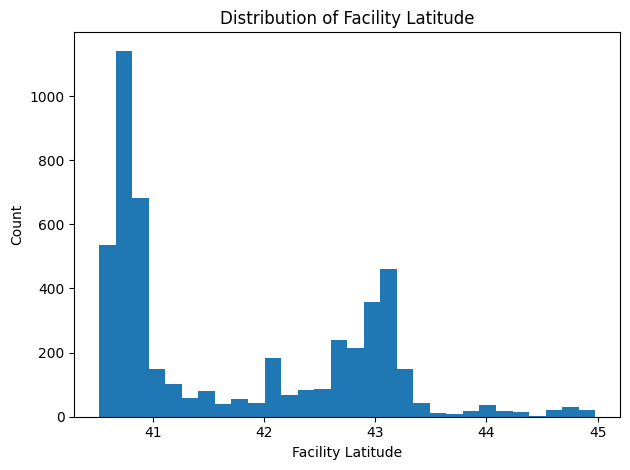

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(fac_csv["facility_latitude"].dropna(), bins=30)
plt.xlabel("Facility Latitude")
plt.ylabel("Count")
plt.title("Distribution of Facility Latitude")
plt.tight_layout()
plt.show()


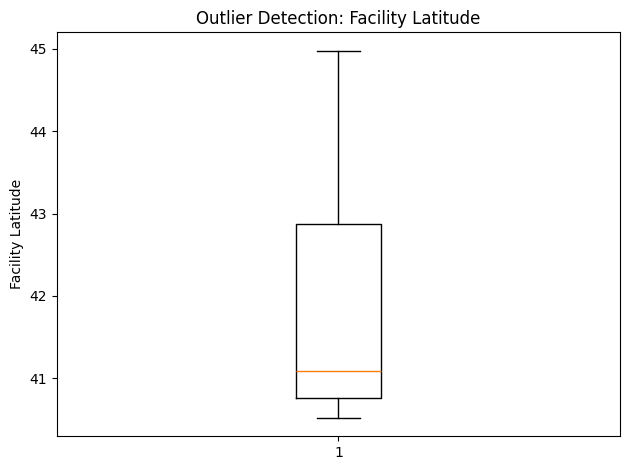

In [63]:
plt.figure()
plt.boxplot(fac_csv["facility_latitude"].dropna(), vert=True)
plt.ylabel("Facility Latitude")
plt.title("Outlier Detection: Facility Latitude")
plt.tight_layout()
plt.show()


In [64]:
fac_csv["facility_latitude"].describe()


,facility_latitude
count,4960.000000
mean,41.735133
std,1.115762
min,40.516773
25%,40.753628
50%,41.085932
75%,42.875748
max,44.978494


Facility latitude was selected as a representative continuous numeric attribute for exploratory data analysis. Histogram and boxplot visualizations revealed the geographic distribution of facilities across New York State, with a small number of outliers likely attributable to data entry or geocoding inconsistencies.